# Application of classification model

This data was extracted from the census bureau database found at
http://www.census.gov/ftp/pub/DES/www/welcome.html
Donor: Ronny Kohavi and Barry Becker,
Data Mining and Visualization
Silicon Graphics.
e-mail: ronnyk@sgi.com for questions.
Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
48842 instances, mix of continuous and discrete (train=32561, test=16281)
45222 if instances with unknown values are removed (train=30162, test=15060)
Duplicate or conflicting instances : 6
Class probabilities for adult.all file
Probability for the label '>50K' : 23.93% / 24.78% (without unknowns)
Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)

Extraction was done by Barry Becker from the 1994 Census database. A set of
reasonably clean records was extracted using the following conditions:
((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) Prediction task is to
determine whether a person makes over 50K a year. Conversion of original data as
follows:
1. Discretized a gross income into two ranges with threshold 50,000.
2. Convert U.S. to US to avoid periods.
3. Convert Unknown to "?"
4. Run MLC++ GenCVFiles to generate data,test.
Description of fnlwgt (final weight)
The weights on the CPS files are controlled to independent estimates of the civilian
noninstitutional population of the US. These are prepared monthly for us by Population
Division here at the Census Bureau. We use 3 sets of controls.
These are:
1. A single cell estimate of the population 16+ for each state.
2. Controls for Hispanic Origin by age and sex.
3. Controls by Race, age and sex.
We use all three sets of controls in our weighting program and "rake" through them 6
times so that by the end we come back to all the controls we used.
The term estimate refers to population totals derived from CPS by creating "weighted
tallies" of any specified socio-economic characteristics of the population. People with
similar demographic characteristics should have similar weights. There is one important
caveat to remember about this statement. That is that since the CPS sample is actually a
collection of 51 state samples, each with its own probability of selection, the statement
only applies within state.

## Importing libraries

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE, RFECV

## Load data

In [61]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None,na_values="?")

test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None,na_values="?")

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
'occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
'native_country', 'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

In [62]:
print(train_set.shape)
print(test_set.shape)

(32561, 15)
(16281, 15)


## View train and test data

In [63]:
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [64]:
test_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


### Check if null data exists in train and test data 

In [65]:
train_set.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

In [66]:
test_set.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

### Check if data contains any categorical columns

In [67]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [68]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education_num     16281 non-null int64
marital_status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital_gain      16281 non-null int64
capital_loss      16281 non-null int64
hours_per_week    16281 non-null int64
native_country    16281 non-null object
wage_class        16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


Get datatypes of train and test data

In [69]:
train_data_types=pd.DataFrame(train_set.dtypes,columns=['datatype'])
test_data_types=pd.DataFrame(test_set.dtypes,columns=['datatype'])

Get categorical columns from train and test data

In [70]:
train_data_obj=train_data_types[train_data_types['datatype']=='object'].reset_index()
test_data_obj=test_data_types[test_data_types['datatype']=='object'].reset_index()

Check unique values in the categorical columns

In [71]:
for i in train_data_obj['index']:
    print('-'*50)
    print("unique values for : ",i)
    print(train_set[i].value_counts())

--------------------------------------------------
unique values for :  workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
--------------------------------------------------
unique values for :  education
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64
--------------------------------------------------
unique values for :  marital_status
 Married-civ-spouse       14976
 Never-married            10683
 Divorced     

In [72]:
for i in test_data_obj['index']:
    print('-'*50)
    print("unique values for : ",i)
    print(test_set[i].value_counts())

--------------------------------------------------
unique values for :  workclass
 Private             11210
 Self-emp-not-inc     1321
 Local-gov            1043
 ?                     963
 State-gov             683
 Self-emp-inc          579
 Federal-gov           472
 Without-pay             7
 Never-worked            3
Name: workclass, dtype: int64
--------------------------------------------------
unique values for :  education
 HS-grad         5283
 Some-college    3587
 Bachelors       2670
 Masters          934
 Assoc-voc        679
 11th             637
 Assoc-acdm       534
 10th             456
 7th-8th          309
 Prof-school      258
 9th              242
 12th             224
 Doctorate        181
 5th-6th          176
 1st-4th           79
 Preschool         32
Name: education, dtype: int64
--------------------------------------------------
unique values for :  marital_status
 Married-civ-spouse       7403
 Never-married            5434
 Divorced                 2190
 

### Convert categorical values into numeric values

In [73]:
from sklearn.preprocessing import LabelEncoder

lb_encode=LabelEncoder()

for i in train_data_obj['index']:
    train_set[i]=lb_encode.fit_transform(train_set[i])
    
for i in test_data_obj['index']:
    test_set[i]=lb_encode.fit_transform(test_set[i])

In [74]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null int64
fnlwgt            32561 non-null int64
education         32561 non-null int64
education_num     32561 non-null int64
marital_status    32561 non-null int64
occupation        32561 non-null int64
relationship      32561 non-null int64
race              32561 non-null int64
sex               32561 non-null int64
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null int64
wage_class        32561 non-null int64
dtypes: int64(15)
memory usage: 3.7 MB


In [75]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null int64
fnlwgt            16281 non-null int64
education         16281 non-null int64
education_num     16281 non-null int64
marital_status    16281 non-null int64
occupation        16281 non-null int64
relationship      16281 non-null int64
race              16281 non-null int64
sex               16281 non-null int64
capital_gain      16281 non-null int64
capital_loss      16281 non-null int64
hours_per_week    16281 non-null int64
native_country    16281 non-null int64
wage_class        16281 non-null int64
dtypes: int64(15)
memory usage: 1.9 MB


## Data Visualization

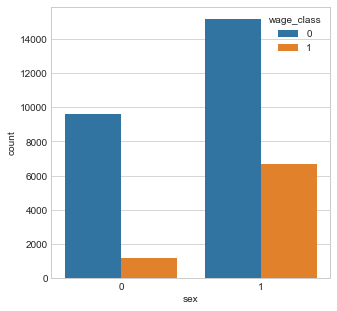

In [76]:
plt.figure(figsize=(5,5))
sns.set_style('whitegrid')
sns.countplot('sex',data=train_set,hue='wage_class')

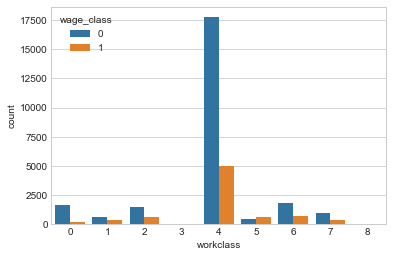

In [77]:
sns.countplot('workclass',data=train_set,hue='wage_class')

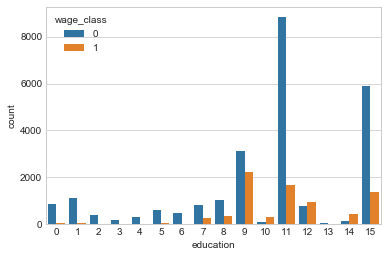

In [78]:
sns.countplot('education',data=train_set,hue='wage_class')

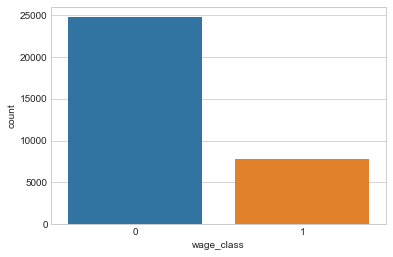

In [79]:
sns.countplot('wage_class',data=train_set)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b804fd0>,
      dtype=object)

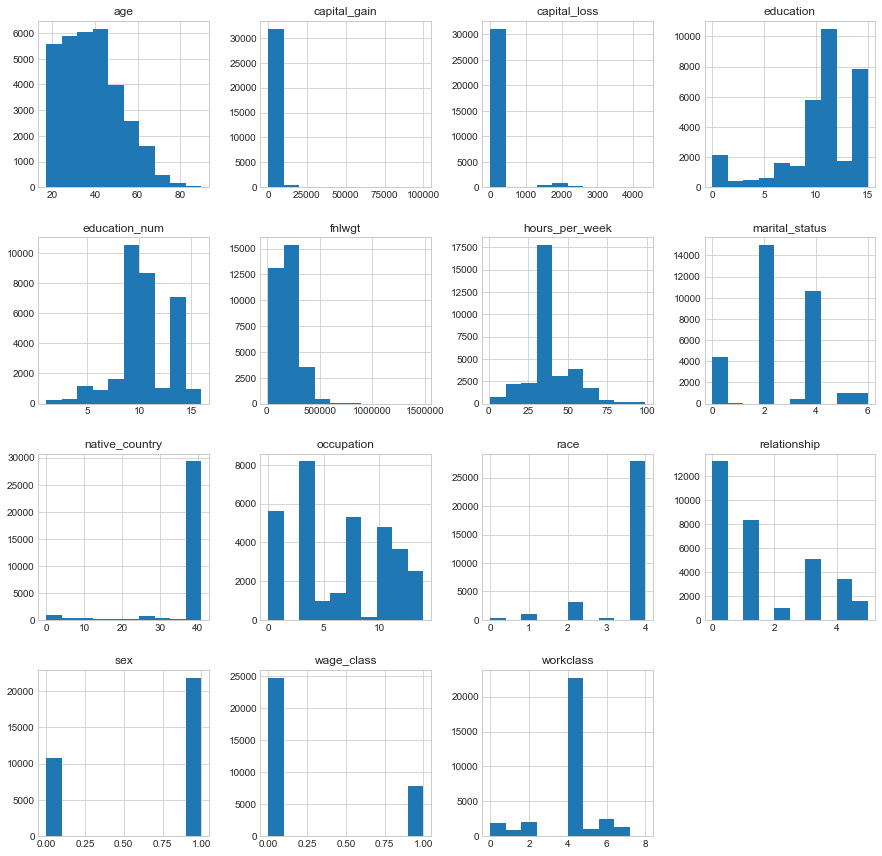

In [80]:
pd.DataFrame.hist(train_set,figsize = [15,15])

### Define training and test sets

In [81]:
x_train = train_set.drop(['wage_class'],axis=1)
y_train = train_set['wage_class']

x_test = test_set.drop(['wage_class'],axis=1)
y_test = test_set['wage_class']

#### Check with different classification model

##  Logistic regression

In [82]:
model_accuracy = {}
#Build the model
LR = LogisticRegression()
#traing the model 
LR.fit(x_train,y_train)
#Model parameters study
y_pred = LR.predict(x_test)
y_pred_proba = LR.predict_proba(x_test)
# generate evaluation metrics
print(metrics.accuracy_score(y_test, y_pred))
model_accuracy['Logistic Regression'] = metrics.accuracy_score(y_test, y_pred)

0.795589951477182


### Evaluation of Logistic regression

##### Confusion matrix

In [83]:
metrics.confusion_matrix(y_test,y_pred)

array([[11843,   592],
       [ 2736,  1110]])

##### ROC and AUC

In [84]:
print("ROC : ",(metrics.roc_curve(y_test,y_pred_proba[:,1])))
print("AUC : ",(metrics.roc_auc_score(y_test,y_pred_proba[:,1])))

ROC :  (array([0.        , 0.        , 0.        , ..., 0.99879373, 0.99879373,
       1.        ]), array([2.60010400e-04, 2.60010400e-03, 3.64014561e-03, ...,
       9.99739990e-01, 1.00000000e+00, 1.00000000e+00]), array([1.        , 1.        , 1.        , ..., 0.04557042, 0.04357185,
       0.00776231]))
AUC :  0.7002772085149589


In [85]:
model_accuracy['AUC_Logistic_Regression'] = metrics.roc_auc_score(y_test,y_pred_proba[:,1])

##### Classification report

In [86]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.81      0.95      0.88     12435
          1       0.65      0.29      0.40      3846

avg / total       0.77      0.80      0.76     16281



##### 10 fold cross validation

In [87]:
Features = x_train.append(x_test)
Labels = y_train.append(y_test)

In [88]:
scores = cross_val_score(estimator= LogisticRegression(),     # Model to test
                X= Features,  
                y = Labels,                                   # Target variable
                scoring = "accuracy",                         # Scoring metric    
                cv=10)                                        # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_accuracy['10 CV Score-Logistic Regression'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.78853634 0.79918117 0.80348004 0.79119754 0.78710338 0.78951679
 0.80958231 0.80483309 0.7837395  0.79213598]
Average accuracy:  0.7949306144577417


## Decision Tree Classifier

In [89]:
#build the model
DT = DecisionTreeClassifier(random_state=0)
#train the model
DT.fit(x_train,y_train)
#Model parameters study
y_pred = DT.predict(x_test)
y_pred_proba = DT.predict_proba(x_test)
# Check accuracy score
print("accuracy of Decision Tree Classifier :",metrics.accuracy_score(y_test, y_pred))

accuracy of Decision Tree Classifier : 0.8100853755911799


##### Build decision tree classifier with max_depth 1 to 20

In [90]:
for depth in range(20):
    #build the model
    depth = depth + 1
    DT = DecisionTreeClassifier(max_depth=depth,random_state=0)
    #train the model
    DT.fit(x_train,y_train)
    #Model parameters study
    y_pred = DT.predict(x_test)
    y_pred_proba = DT.predict_proba(x_test)
    # generate evaluation metrics
    print("accuracy of Decision Tree Classifier for max_depth ", depth," : ",metrics.accuracy_score(y_test, y_pred))
 

accuracy of Decision Tree Classifier for max_depth  1  :  0.7637737239727289
accuracy of Decision Tree Classifier for max_depth  2  :  0.8267919660954487
accuracy of Decision Tree Classifier for max_depth  3  :  0.839199066396413
accuracy of Decision Tree Classifier for max_depth  4  :  0.8442356120631411
accuracy of Decision Tree Classifier for max_depth  5  :  0.8514219028315214
accuracy of Decision Tree Classifier for max_depth  6  :  0.8546772311283091
accuracy of Decision Tree Classifier for max_depth  7  :  0.8563970272096308
accuracy of Decision Tree Classifier for max_depth  8  :  0.8538787543762668
accuracy of Decision Tree Classifier for max_depth  9  :  0.8513604815429028
accuracy of Decision Tree Classifier for max_depth  10  :  0.8551071801486395
accuracy of Decision Tree Classifier for max_depth  11  :  0.8522203795835637
accuracy of Decision Tree Classifier for max_depth  12  :  0.8519132731404705
accuracy of Decision Tree Classifier for max_depth  13  :  0.8495792641729

As the highest accuracy level at max_depth 10. Now Build the model with max_depth 10

In [91]:
#build the model
DT = DecisionTreeClassifier(max_depth=10, random_state=0)
#train the model
DT.fit(x_train,y_train)
#Model parameters study
y_pred = DT.predict(x_test)
y_pred_proba = DT.predict_proba(x_test)
# Check accuracy score
print("accuracy of Decision Tree Classifier :",metrics.accuracy_score(y_test, y_pred))

accuracy of Decision Tree Classifier : 0.8551071801486395


### Evaluation of decision tree classifier model

##### Confusion matrix

In [92]:
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, y_pred))

Confusion matrix: 
 [[11725   710]
 [ 1649  2197]]


##### ROC and AUC

In [93]:
print("ROC : ",(metrics.roc_curve(y_test,y_pred_proba[:,1])))
print("AUC : ",(metrics.roc_auc_score(y_test,y_pred_proba[:,1])))
model_accuracy['AUC of Decision tree classifier of depth 10'] = metrics.roc_auc_score(y_test,y_pred_proba[:,1])

ROC :  (array([0.        , 0.00514676, 0.00522718, 0.00522718, 0.0053076 ,
       0.0053076 , 0.00627262, 0.01318858, 0.01391234, 0.01439485,
       0.01439485, 0.01447527, 0.03176518, 0.03313229, 0.03409731,
       0.03433856, 0.03819863, 0.03916365, 0.04045034, 0.04093285,
       0.04189787, 0.04358665, 0.04382791, 0.05653398, 0.0570969 ,
       0.05717732, 0.05942903, 0.06425412, 0.06481705, 0.06521914,
       0.06554081, 0.06883796, 0.06907921, 0.06915963, 0.08781665,
       0.09183756, 0.10985123, 0.11676719, 0.11700844, 0.11966224,
       0.12448733, 0.12971452, 0.13003619, 0.13196622, 0.16574186,
       0.16911942, 0.16976277, 0.17466828, 0.18769602, 0.18809811,
       0.18890229, 0.19131484, 0.19437073, 0.1946924 , 0.19879373,
       0.20514676, 0.20627262, 0.20675513, 0.21182147, 0.21310816,
       0.22525131, 0.23852031, 0.25814234, 0.26320869, 0.26353036,
       0.26586248, 0.27117008, 0.28242863, 0.28258947, 0.28427825,
       0.28854041, 0.29223965, 0.29288299, 0.29489345,

##### 10 fold cross validation

In [94]:
scores = cross_val_score(estimator= DecisionTreeClassifier(max_depth=10, random_state=0),     # Model to test
                X= Features,  
                y = Labels,                                   # Target variable
                scoring = "accuracy",                         # Scoring metric    
                cv=10)                                        # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_accuracy['10 CV Score-Logistic Regression'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.85322416 0.85813715 0.85342886 0.8616172  0.86243603 0.85974611
 0.84848485 0.85459758 0.85111612 0.85091133]
Average accuracy:  0.8553699381987601


## K nearest neighbor

In [95]:
k = []
scores = []
errors = []
for K in range(30):
    K_value = K+1
    neigh = KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
    neigh.fit(x_train,y_train) 
    y_pred = neigh.predict(x_test)
    print("Accuracy is ", metrics.accuracy_score(y_test,y_pred)*100,"% for K-Value:",K_value)
    print("Error  is ", 100 - metrics.accuracy_score(y_test,y_pred)*100,"% for K-Value:",K_value)
    k.append(K_value)
    scores.append(metrics.accuracy_score(y_test,y_pred)*100)
    errors.append(1 - metrics.accuracy_score(y_test,y_pred) )

Accuracy is  72.8579325594251 % for K-Value: 1
Error  is  27.142067440574905 % for K-Value: 1
Accuracy is  78.39199066396412 % for K-Value: 2
Error  is  21.608009336035877 % for K-Value: 2
Accuracy is  75.94128124808059 % for K-Value: 3
Error  is  24.058718751919415 % for K-Value: 3
Accuracy is  79.08605122535471 % for K-Value: 4
Error  is  20.91394877464529 % for K-Value: 4
Accuracy is  77.61194029850746 % for K-Value: 5
Error  is  22.388059701492537 % for K-Value: 5
Accuracy is  79.26417296234874 % for K-Value: 6
Error  is  20.735827037651262 % for K-Value: 6
Accuracy is  78.45341195258277 % for K-Value: 7
Error  is  21.54658804741723 % for K-Value: 7
Accuracy is  79.52214237454702 % for K-Value: 8
Error  is  20.477857625452984 % for K-Value: 8
Accuracy is  78.96320864811743 % for K-Value: 9
Error  is  21.03679135188257 % for K-Value: 9
Accuracy is  79.83539094650206 % for K-Value: 10
Error  is  20.16460905349794 % for K-Value: 10
Accuracy is  79.5098581168233 % for K-Value: 11
Error

Text(0.5,1,'K Value vs Accuracy')

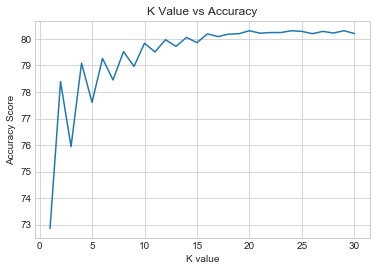

In [96]:
plt.plot(k,scores)
plt.xlabel('K value')
plt.ylabel('Accuracy Score')
plt.title('K Value vs Accuracy')

So, it is showing that after k = 20 accuracy score remains almost same. Optimum value 20

In [97]:
knn = KNeighborsClassifier(n_neighbors = 20, weights='uniform', algorithm='auto')
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
y_pred_proba = knn.predict_proba(x_test)
# generate evaluation metrics
print("accuracy of KNN Classifier :",metrics.accuracy_score(y_test, y_pred))
model_accuracy['Accuracy Score of KNN Classifier neigbors-20'] = metrics.accuracy_score(y_test, y_pred)

model_accuracy['AUC of KNN Classifier neighbors-20'] = metrics.roc_auc_score(y_test,y_pred_proba[:,1])

accuracy of KNN Classifier : 0.8030833486886555


### Evaluation of K nearest neighbor model where K = 20

##### Confusion matrix

In [98]:
print("Confusion metrix: \n",metrics.confusion_matrix(y_test, y_pred))

Confusion metrix: 
 [[12277   158]
 [ 3048   798]]


##### ROC and AUC

In [99]:
print("ROC", metrics.roc_curve(y_test,y_pred_proba[:,1]))
print("AUC", metrics.roc_auc_score(y_test,y_pred_proba[:,1]))

ROC (array([0.00000000e+00, 3.21672698e-04, 4.02090873e-04, 5.62927222e-04,
       6.43345396e-04, 1.20627262e-03, 1.84961801e-03, 3.05589063e-03,
       4.58383595e-03, 7.31805388e-03, 1.27060716e-02, 2.13108162e-02,
       3.66706876e-02, 6.86771210e-02, 1.22557298e-01, 2.11017290e-01,
       3.56011259e-01, 5.30438279e-01, 7.26819461e-01, 8.85404101e-01,
       9.74829111e-01, 1.00000000e+00]), array([0.        , 0.07670307, 0.09958398, 0.11336453, 0.12584503,
       0.13624545, 0.14534581, 0.15236609, 0.16458658, 0.18434737,
       0.2074883 , 0.22724909, 0.25611024, 0.29589184, 0.35179407,
       0.44071763, 0.55694228, 0.68356734, 0.82293292, 0.93837754,
       0.98959958, 1.        ]), array([2.  , 1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55,
       0.5 , 0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05, 0.  ]))
AUC 0.6484265032040767


##### 10 fold cross validation

In [100]:
scores = cross_val_score(estimator= KNeighborsClassifier(n_neighbors = 20, weights='uniform', algorithm='auto'),     # Model to test
                X= Features,  
                y = Labels,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_accuracy['10 CV Score-KNN Classifier neighbors-20'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.80143296 0.80184237 0.80450358 0.80266121 0.79918117 0.7993448
 0.8042588  0.80032767 0.79725579 0.79909891]
Average accuracy:  0.8009907260662927


## Ensemble model - Bagging

In [101]:
bag_LR = BaggingClassifier(LogisticRegression(),
                            n_estimators=10, max_samples=0.5,
                            bootstrap=True, random_state=3) 

bag_LR.fit(x_train,y_train)
y_pred = bag_LR.predict(x_test)
y_pred_proba = bag_LR.predict_proba(x_test)
model_accuracy['Accuracy Score-Bagging-Logistic Regression'] = metrics.accuracy_score(y_test,y_pred)
model_accuracy['AUC-Bagging-Logistic Regression'] = metrics.roc_auc_score(y_test,y_pred_proba[:,1])
print("Accuracy score", metrics.accuracy_score(y_test,y_pred))

Accuracy score 0.7941158405503348


In [102]:
print("Confusion metrix: ", metrics.confusion_matrix(y_test,y_pred))
print("ROC: ",metrics.roc_curve(y_test,y_pred_proba[:,1]))
print("AUC: ",metrics.roc_auc_score(y_test,y_pred_proba[:,1]))

Confusion metrix:  [[11825   610]
 [ 2742  1104]]
ROC:  (array([0.        , 0.        , 0.        , ..., 0.99863289, 0.99863289,
       1.        ]), array([2.60010400e-04, 3.38013521e-03, 4.16016641e-03, ...,
       9.99739990e-01, 1.00000000e+00, 1.00000000e+00]), array([1.        , 1.        , 1.        , ..., 0.05427653, 0.05000936,
       0.01052552]))
AUC:  0.7154527620590148


#### Bagging with KNN model

In [103]:
bag_KNN = BaggingClassifier(KNeighborsClassifier(n_neighbors = 20, weights='uniform', algorithm='auto'),
                            n_estimators=10, max_samples=0.5,
                            bootstrap=True, random_state=3) 

bag_KNN.fit(x_train,y_train)
y_pred = bag_KNN.predict(x_test)
y_pred_proba = bag_KNN.predict_proba(x_test)
print("Accuracy Score: ", metrics.accuracy_score(y_test, y_pred))
model_accuracy['Accuracy Score-Bagging-KNN neighbors -20'] = metrics.accuracy_score(y_test,y_pred)
model_accuracy['AUC-Bagging-KNN neighbors -20'] = metrics.roc_auc_score(y_test,y_pred_proba[:,1])

Accuracy Score:  0.7989067010625883


#### Random forrest classifier model

In [104]:
RF = RandomForestClassifier()
RF.fit(x_train,y_train)
y_pred = RF.predict(x_test)
y_pred_proba = RF.predict_proba(x_test)
print("accuracy of Random Forest Classifier :",metrics.accuracy_score(y_test, y_pred))
model_accuracy['Accuracy score of Random Forest Classifier'] = metrics.accuracy_score(y_test, y_pred)

accuracy of Random Forest Classifier : 0.8483508384005897


In [105]:
print("Confusion metrix: ", metrics.confusion_matrix(y_test,y_pred))
print("ROC: ",metrics.roc_curve(y_test,y_pred_proba[:,1]))
print("AUC: ",metrics.roc_auc_score(y_test,y_pred_proba[:,1]))

Confusion metrix:  [[11645   790]
 [ 1679  2167]]
ROC:  (array([0.        , 0.00337756, 0.01045436, 0.02147165, 0.02155207,
       0.03988741, 0.06353036, 0.09802975, 0.09811017, 0.13960595,
       0.13960595, 0.19517491, 0.19517491, 0.27462807, 0.41552071,
       1.        ]), array([0.        , 0.22074883, 0.3224129 , 0.40275611, 0.40275611,
       0.48153926, 0.56344254, 0.64664587, 0.64664587, 0.73166927,
       0.73192928, 0.80707228, 0.80733229, 0.87805512, 0.93889756,
       1.        ]), array([2.        , 1.        , 0.9       , 0.8       , 0.73333333,
       0.7       , 0.6       , 0.5       , 0.46666667, 0.4       ,
       0.34285714, 0.3       , 0.23333333, 0.2       , 0.1       ,
       0.        ]))
AUC:  0.8806401504150234


In [106]:
scores = cross_val_score(estimator= RandomForestClassifier(),     # Model to test
                X= Features,  
                y = Labels,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_accuracy['10 CV Score-Random Forest Classifier'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.84892528 0.8468782  0.84728762 0.85486182 0.84994882 0.85298935
 0.8490991  0.85398321 0.84722507 0.85459758]
Average accuracy:  0.8505796049164012


## Ensemble model - Boosting

In [107]:
from xgboost.sklearn import XGBClassifier
#set the parameters for the xgbosst model
params = {
    'objective': 'binary:logistic',
    'max_depth': 2,
    'learning_rate': 1.0,
    'silent': 1.0,
    'n_estimators': 5
}
params['eval_metric'] = ['logloss', 'auc']
bst = XGBClassifier(**params).fit(x_train,y_train)
y_pred = bst.predict(x_test)
y_pred_proba = bst.predict_proba(x_test)
print("accuracy of XGBoost :",metrics.accuracy_score(y_test, y_pred))

accuracy of XGBoost : 0.8499477919046742


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [108]:
print("Confusion metrix: ", metrics.confusion_matrix(y_test,y_pred))
print("ROC: ",metrics.roc_curve(y_test,y_pred_proba[:,1]))
print("AUC: ",metrics.roc_auc_score(y_test,y_pred_proba[:,1]))

Confusion metrix:  [[11544   891]
 [ 1552  2294]]
ROC:  (array([0.00000000e+00, 0.00000000e+00, 8.04181745e-05, 1.60836349e-04,
       1.60836349e-04, 1.60836349e-04, 1.60836349e-04, 1.60836349e-04,
       1.60836349e-04, 2.41254524e-04, 2.41254524e-04, 2.41254524e-04,
       2.41254524e-04, 3.21672698e-04, 3.21672698e-04, 4.02090873e-04,
       4.02090873e-04, 4.02090873e-04, 4.02090873e-04, 4.02090873e-04,
       4.02090873e-04, 7.23763571e-04, 8.04181745e-04, 8.04181745e-04,
       8.04181745e-04, 8.04181745e-04, 8.04181745e-04, 8.84599920e-04,
       8.84599920e-04, 8.84599920e-04, 8.84599920e-04, 8.84599920e-04,
       8.84599920e-04, 9.65018094e-04, 9.65018094e-04, 9.65018094e-04,
       9.65018094e-04, 1.72899075e-02, 1.72899075e-02, 1.72899075e-02,
       1.73703257e-02, 1.74507439e-02, 1.79332529e-02, 1.79332529e-02,
       1.80136711e-02, 1.80940893e-02, 1.84961801e-02, 2.05066345e-02,
       2.05066345e-02, 2.05870527e-02, 2.05870527e-02, 2.09087254e-02,
       3.77161238e-0

In [109]:
model_accuracy['AUC for XGBOOST model'] = metrics.roc_auc_score(y_test,y_pred_proba[:,1])

## Important feature selection

In [110]:
selector =  RFECV(estimator=RandomForestClassifier(), step=1,cv=10)
selector.fit(Features,Labels)
ranks = selector.ranking_.tolist()
df_rank_cv = pd.DataFrame({'Feature':Features.columns,'Rank':ranks})
df_rank_cv

,Feature,Rank
0,age,1
1,workclass,1
2,fnlwgt,1
3,education,2
4,education_num,1
5,marital_status,1
6,occupation,1
7,relationship,1
8,race,3
9,sex,4


In [111]:
impcvRF= df_rank_cv.Feature[df_rank_cv.Rank == 1]
print("The important Features in the sample data after REFCV are as follows :-\n",impcvRF.values)

The important Features in the sample data after REFCV are as follows :-
 ['age' 'workclass' 'fnlwgt' 'education_num' 'marital_status' 'occupation'
 'relationship' 'capital_gain' 'capital_loss' 'hours_per_week'
 'native_country']


## Evaluation of highest accuracy of classification model for this data

In [112]:
features = []
scores = []
for k,v in model_accuracy.items():
    features.append(k)
    scores.append(v)
df_scores = pd.DataFrame({'Features':features,'Scores':scores})
feat_cols = ['Features','Scores']
df_scores = df_scores[feat_cols]
df_scores

,Features,Scores
0,Logistic Regression,0.795590
1,AUC_Logistic_Regression,0.700277
2,10 CV Score-Logistic Regression,0.855370
3,AUC of Decision tree classifier of depth 10,0.892387
4,Accuracy Score of KNN Classifier neigbors-20,0.803083
5,AUC of KNN Classifier neighbors-20,0.648427
6,10 CV Score-KNN Classifier neighbors-20,0.800991
7,Accuracy Score-Bagging-Logistic Regression,0.794116
8,AUC-Bagging-Logistic Regression,0.715453
9,Accuracy Score-Bagging-KNN neighbors -20,0.798907


From the AUC score, it is evident that Decision tree with depth 10 and XGBoost model has the highest accuracy for model performance